# 深度学习基础

## 线性回归

广义上讲，当数据样本数为n，特征数为d时，线性回归的矢量计算表达式为：

$$
\hat{y} = Xw + b
$$

其中输出$\hat{y} \in \mathbb{R}^{n \times 1}$批量数据样本特征$X \in \mathbb{R}^{n \times d}$，偏差$b \in \mathbb{R}$，批量数据标签$y \in \mathbb{R}^{n \times 1}$，设模型参数为$\theta = [W_1, W_2, b]^T$，则损失函数为：

$$
l(\theta) = \frac{1}{2n}(\hat{y} - y)^T(\hat{y} - y)
$$

小批量随机梯度下降的步骤：

$$
\boldsymbol{\theta} \leftarrow \boldsymbol{\theta}-{ }_{|\mathcal{B}|}^{\eta} \sum_{i \in \mathcal{B}} \nabla_{\boldsymbol{\theta}} \ell^{(i)}(\boldsymbol{\theta})
$$

其中梯度的损失：

$$
\nabla_{\boldsymbol{\theta}} \ell^{(i)}(\boldsymbol{\theta})=\left[\begin{array}{l}
\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right) \\
\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right) \\
\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right) \\
\partial b
\end{array}\right]=\left[\begin{array}{c}
x_{1}^{(i)}\left(x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}\right) \\
x_{2}^{(i)}\left(x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}\right) \\
x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}
\end{array}\right]=\left[\begin{array}{c}
x_{1}^{(i)} \\
x_{2}^{(i)} \\
1
\end{array}\right]\left(\hat{y}^{(i)}-y^{(i)}\right)

$$

## 线性回归从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

设给定的训练数据样本数为1000，输入特征数为2。则给的随机生成的批量样本特征$X \in \mathbb{R}^{1000 \times 2}$，设线性回归模型的真实权重$W = [2, -3.4]^T$和偏差$b = 4.2$，以及一个随机噪声项来生成标签：

$$
y = Xw + b + \epsilon
$$

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

In [3]:
print(features[0], labels[0])

tensor([-0.8668,  0.7273]) tensor(-0.0150)


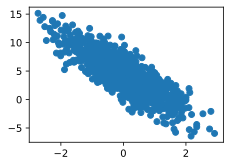

In [4]:
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy())

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-1.4268, -1.1344],
        [-0.6100, -1.3442],
        [-1.8321,  0.3881],
        [-0.3766, -0.8791],
        [ 0.7168, -1.4920],
        [-0.2559,  0.0089],
        [ 0.2351,  0.7245],
        [ 1.1995,  1.1879],
        [-1.1944, -1.5038],
        [ 1.9129,  0.4022]]) tensor([ 5.2074,  7.5406, -0.7903,  6.4372, 10.7225,  3.6491,  2.1985,  2.5748,
         6.9347,  6.6656])


In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [8]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [10]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.063598
epoch 2, loss 0.000359
epoch 3, loss 0.000051


In [12]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9982],
        [-3.3986]], requires_grad=True)
4.2 
 tensor([4.1995], requires_grad=True)


## 线性回归的简洁实现



In [13]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

In [14]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量数据
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0.2941,  0.8852],
        [-0.5107, -0.1225],
        [-0.5942, -1.4709],
        [ 0.6385,  0.8257],
        [-1.4878, -2.2931],
        [ 1.7777,  0.7039],
        [ 0.1572,  0.4401],
        [-1.3602,  2.1822],
        [ 0.5574, -0.5662],
        [-0.2832,  0.3666]]) tensor([ 1.7717,  3.5937,  8.0205,  2.6603,  8.9923,  5.3552,  3.0196, -5.9349,
         7.2389,  2.3822])


In [15]:
from torch import nn

class LinearNet(nn.Module):
    def __init__(self, n_features):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


另外三种写法

```python
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))
```

In [16]:
# 可学习的参数
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1535, -0.1708]], requires_grad=True)
Parameter containing:
tensor([-0.0108], requires_grad=True)


In [17]:
from torch.nn import init

# 初始化模型参数
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [18]:
# 定义损失函数

loss = nn.MSELoss()

In [19]:
# 定义优化算法

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


还可以为不同子网络设置不同的学习率，这在finetune时经常用到。例：

```
optimizer =optim.SGD([
                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
                {'params': net.subnet1.parameters()}, # lr=0.03
                {'params': net.subnet2.parameters(), 'lr': 0.01}
            ], lr=0.03)
```

有时候不想让学习率固定成一个常数，那如何调整学习率呢？主要有两种做法。一种是修改optimizer.param_groups中对应的学习率，另一种是更简单也是较为推荐的做法——新建优化器，由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。但是后者对于使用动量的优化器（如Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

```
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍
```

In [20]:
# 训练模型

num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000447
epoch 2, loss: 0.000050
epoch 3, loss: 0.000081


In [21]:
dense = net.linear
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0001, -3.4000]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1998], requires_grad=True)


## softmax 回归

softmax会线性回归类似，都是输入特征与权重进行线性叠加，但softmax回归的输出值个数等于标签里的类别数。


假设有4种特征和3中输出标签类别，则输出$o_1, o_2, o_3$

$$
\begin{array}{l}
o_{1}=x_{1} w_{11}+x_{2} w_{21}+x_{3} w_{31}+x_{4} w_{41}+b_{1} \\
o_{2}=x_{1} w_{12}+x_{2} w_{22}+x_{3} w_{32}+x_{4} w_{42}+b_{2} \\
o_{3}=x_{1} w_{13}+x_{2} w_{23}+x_{3} w_{33}+x_{4} w_{43}+b_{3}
\end{array}
$$

然后进行softmax变换，使输出值变为正值且和为一的概率分布：

$$
\hat{y}_{1}, \hat{y}_{2}, \hat{y}_{3}=\operatorname{softmax}\left(o_{1}, o_{2}, o_{3}\right)
$$

其中$\hat{y}_{j} = \frac{e^{o_j}}{\sum_{i=1}^{3} e^{o_i}}$

用矩阵表示：

$$
O = XW + b \\
\hat{Y} = softmax(O)
$$

平方损失函数不能很好的度量其差异，因此采用交叉熵损失函数：

$$
l(\Theta) = \frac{1}{n} \sum_{i=0}^{n} H(y^i, \hat{y}^i)
$$

其中$H(y^i, \hat{y}^i) = - \sum_{j=1}^{q} y_{j}^{i} \log \hat{y}_{j}^{i}$代表交叉熵。

## 图像分类数据

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
import d2l_pytorch as d2l

In [23]:
mnist_train = torchvision.datasets.FashionMNIST("./Datasets/FashionMNIST", train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST("./Datasets/FashionMNIST", train=False, download=True, transform=transforms.ToTensor())

In [24]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [25]:
feature, label = mnist_train[0]
print(feature.shape, label) # Channel X Height X Width

torch.Size([1, 28, 28]) 9


In [26]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [27]:
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

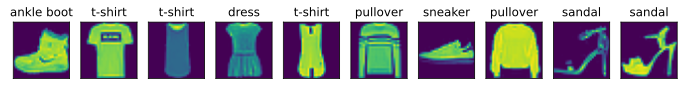

In [28]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [29]:
# 读取小批量

batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [30]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

3.25 sec


## softmax回归的从零开始

In [31]:
import torch
import torchvision
import numpy as np
import d2l_pytorch as d2l

In [32]:
batch_size = 256

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [33]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.requires_grad_(requires_grad = True)
b.requires_grad_(requires_grad = True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [34]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

In [35]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

In [36]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

In [37]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [38]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [39]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step() 

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


epoch 1, loss 0.7837, train acc 0.751, test acc 0.797
epoch 2, loss 0.5693, train acc 0.813, test acc 0.812
epoch 3, loss 0.5265, train acc 0.824, test acc 0.821
epoch 4, loss 0.5017, train acc 0.832, test acc 0.826
epoch 5, loss 0.4851, train acc 0.838, test acc 0.823


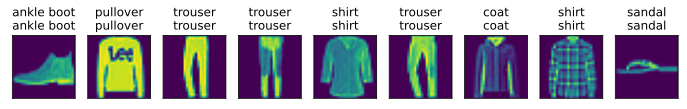

In [40]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

## softmax回归简洁实现

In [41]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import d2l_pytorch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y

net = LinearNet(num_inputs, num_outputs)

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

from collections import OrderedDict

net = nn.Sequential(
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0) 

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.750, test acc 0.788
epoch 2, loss 0.0022, train acc 0.813, test acc 0.783
epoch 3, loss 0.0021, train acc 0.825, test acc 0.814
epoch 4, loss 0.0020, train acc 0.832, test acc 0.819
epoch 5, loss 0.0019, train acc 0.836, test acc 0.803


## 模型选择、欠拟合和过拟合

训练误差（training error）和泛化误差（generalization error）：通俗来讲，前者指模型在训练数据集上表现出的误差，后者指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。

机器学习模型应关注降低泛化误差。

在机器学习中，通常需要评估若干候选模型的表现并从中选择模型。这一过程称为模型选择（model selection）。可供选择的候选模型可以是有着不同超参数的同类模型。

从严格意义上讲，测试集只能在所有超参数和模型参数选定后使用一次。不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。

由于验证数据集不参与模型训练，当训练数据不够用时，预留大量的验证数据显得太奢侈。一种改善的方法是K折交叉验证（K-fold cross-validation）。在K折交叉验证中，把原始训练数据集分割成K个不重合的子数据集，然后做K次模型训练和验证。每一次使用一个子数据集验证模型，并使用其他K−1个子数据集来训练模型。在这K次训练和验证中，每次用来验证模型的子数据集都不同。最后，对这K次训练误差和验证误差分别求平均。

欠拟合：模型无法得到较低的训练误差。

过拟合：模型的训练误差远小于它在测试数据集上的误差。



In [42]:
# 多项式函数拟合实验

%matplotlib inline
import torch
import numpy as np
import d2l_pytorch as d2l

n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [43]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [44]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

final epoch: train loss 8.114760566968471e-05 test loss 0.0001137625877163373
weight: tensor([[ 1.1979, -3.4006,  5.6002]]) 
bias: tensor([5.0020])


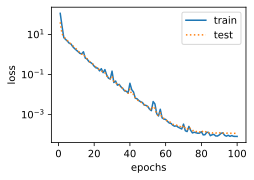

In [45]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 446.01580810546875 test loss 111.3661117553711
weight: tensor([[21.6461]]) 
bias: tensor([-0.6524])


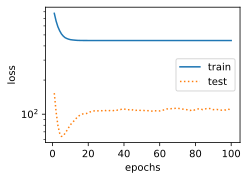

In [46]:
# 欠拟合

fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

final epoch: train loss 0.8573781251907349 test loss 137.4617156982422
weight: tensor([[ 0.7557, -1.3809,  1.3452]]) 
bias: tensor([-1.0146])


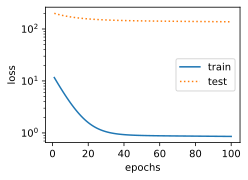

In [47]:
# 过拟合
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

## 权重衰减

* 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

* 权重衰减等价于L2范数正则化，通常会使学到的权重参数的元素较接近0。

* 权重衰减可以通过优化器中的weight_decay超参数来指定。

* 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法。

In [54]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [55]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [56]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [57]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.01645278930664


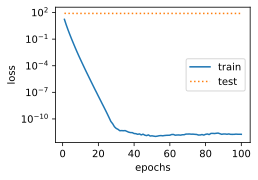

In [58]:
# 过拟合

fit_and_plot(lambd=0)

L2 norm of w: 0.04454248398542404


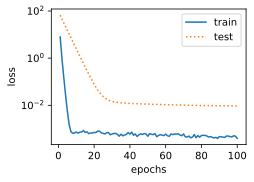

In [59]:
# 加上权重衰减后

fit_and_plot(lambd=3)

In [60]:
# 简洁实现

def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 13.864623069763184


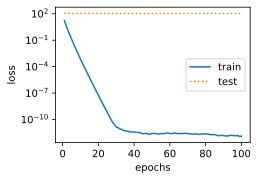

In [61]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.05717557296156883


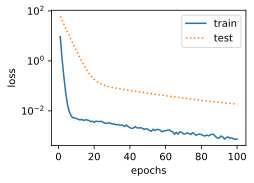

In [62]:
fit_and_plot_pytorch(3)

## 丢弃法

In [63]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import d2l_pytorch as d2l

def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()

    return mask * X / keep_prob

In [64]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  
        H1 = dropout(H1, drop_prob1)  
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3) + b3

In [65]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() 
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() 
        else: 
            if('is_training' in net.__code__.co_varnames): 
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

In [66]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0045, train acc 0.556, test acc 0.760
epoch 2, loss 0.0023, train acc 0.786, test acc 0.802
epoch 3, loss 0.0019, train acc 0.821, test acc 0.791
epoch 4, loss 0.0018, train acc 0.838, test acc 0.826
epoch 5, loss 0.0016, train acc 0.848, test acc 0.843


In [67]:
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0047, train acc 0.541, test acc 0.653
epoch 2, loss 0.0023, train acc 0.783, test acc 0.781
epoch 3, loss 0.0019, train acc 0.819, test acc 0.831
epoch 4, loss 0.0018, train acc 0.834, test acc 0.827
epoch 5, loss 0.0016, train acc 0.846, test acc 0.848


## 实战Kaggle比赛：房价预测

In [68]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import d2l_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.6.0


In [69]:
train_data = pd.read_csv("./data/kaggle_house/train.csv")
test_data = pd.read_csv("./data/kaggle_house/test.csv")

In [70]:
print(train_data.shape)
print(test_data.shap

(1460, 81)
(1459, 80)


In [71]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [72]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [73]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [74]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [75]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

In [76]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [77]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [78]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [79]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [80]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.170594, valid rmse 0.157002
fold 1, train rmse 0.161957, valid rmse 0.189307
fold 2, train rmse 0.163864, valid rmse 0.168032
fold 3, train rmse 0.167148, valid rmse 0.154423
fold 4, train rmse 0.162481, valid rmse 0.182876
5-fold validation: avg train rmse 0.165209, avg valid rmse 0.170328


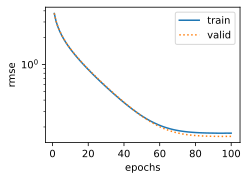

In [81]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [85]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv("./data/kaggle_house/submission.csv", index=False)

train rmse 0.162409


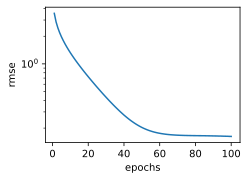

In [87]:
train_and_pred(train_features, test_features, train_labels, 
                test_data, num_epochs, lr, weight_decay, batch_size)